In [ ]:
from dotenv import load_dotenv
import os
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt 
load_dotenv()


True

In [ ]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess a single image for prediction
    """
    try:
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        image = cv2.resize(image, target_size)
        
        # Normalize to [0, 1]
        image = image.astype(np.float32) / 255.0
        
        # Convert from (H, W, C) to (C, H, W)
        image = np.transpose(image, (2, 0, 1))
        
        # Add batch dimension (1, C, H, W)
        image = np.expand_dims(image, axis=0)
        
        # Convert to tensor
        image_tensor = torch.FloatTensor(image)
        
        return image_tensor
        
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

def predict_single_image(model, image_path, class_names, device):
    """
    Predict the class of a single image
    """
    # Preprocess image
    image_tensor = load_and_preprocess_image(image_path)
    
    if image_tensor is None:
        return None, None, None
    
    # Move to device
    image_tensor = image_tensor.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        # Get predictions
        outputs = model(image_tensor)
        
        # Get probabilities using softmax
        probabilities = F.softmax(outputs, dim=1)
        
        # Get predicted class
        _, predicted_idx = torch.max(outputs, 1)
        predicted_idx = predicted_idx.item()
        
        # Get confidence score
        confidence = probabilities[0][predicted_idx].item()
        
        # Get predicted class name
        predicted_class = class_names[predicted_idx]
        
        return predicted_class, confidence, probabilities[0].cpu().numpy()

def predict_multiple_images(model, image_paths, class_names, device):
    """
    Predict classes for multiple images
    """
    results = []
    
    for image_path in image_paths:
        print(f"Predicting: {os.path.basename(image_path)}")
        
        predicted_class, confidence, probabilities = predict_single_image(
            model, image_path, class_names, device
        )
        
        if predicted_class is not None:
            results.append({
                'image_path': image_path,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'probabilities': probabilities
            })
            
            print(f"  Predicted: {predicted_class} (Confidence: {confidence:.4f})")
        else:
            print(f"  Failed to predict")
        
        print("-" * 40)
    
    return results

def visualize_predictions(results, class_names, num_images=6):
    """
    Visualize prediction results with images and probability bars
    """
    if not results:
        print("No results to visualize")
        return
    
    # Limit number of images to display
    results = results[:num_images]
    
    # Calculate grid size
    cols = 3
    rows = (len(results) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows * 2, cols, figsize=(15, rows * 6))
    
    if rows == 1:
        axes = axes.reshape(2, cols)
    
    for idx, result in enumerate(results):
        col = idx % cols
        row_img = (idx // cols) * 2
        row_prob = row_img + 1
        
        # Load and display image
        image = cv2.imread(result['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        axes[row_img, col].imshow(image)
        axes[row_img, col].set_title(
            f"Predicted: {result['predicted_class']}\n"
            f"Confidence: {result['confidence']:.3f}",
            fontsize=12
        )
        axes[row_img, col].axis('off')
        
        # Display probability distribution
        probabilities = result['probabilities']
        colors = ['red' if i == class_names.index(result['predicted_class']) else 'blue' 
                 for i in range(len(class_names))]
        
        bars = axes[row_prob, col].bar(class_names, probabilities, color=colors, alpha=0.7)
        axes[row_prob, col].set_title('Class Probabilities', fontsize=10)
        axes[row_prob, col].set_ylabel('Probability')
        axes[row_prob, col].set_ylim(0, 1)
        axes[row_prob, col].tick_params(axis='x', rotation=45)
        
        # Add probability values on bars
        for bar, prob in zip(bars, probabilities):
            height = bar.get_height()
            axes[row_prob, col].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                                   f'{prob:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Hide empty subplots
    total_subplots = rows * cols
    for idx in range(len(results), total_subplots):
        col = idx % cols
        row_img = (idx // cols) * 2
        row_prob = row_img + 1
        axes[row_img, col].axis('off')
        axes[row_prob, col].axis('off')
    
    plt.tight_layout()
    plt.show()

def get_random_test_images(test_data_dir, num_images=6):
    """
    Get random images from test directory for prediction
    """
    image_paths = []
    
    # Collect all image paths
    for class_folder in os.listdir(test_data_dir):
        class_path = os.path.join(test_data_dir, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_path, image_file))
    
    # Randomly select images
    if len(image_paths) >= num_images:
        selected_images = random.sample(image_paths, num_images)
    else:
        selected_images = image_paths
    
    return selected_images

print("Image prediction functions defined successfully!")
print("Available functions:")
print("- predict_single_image(): Predict one image")
print("- predict_multiple_images(): Predict multiple images")
print("- visualize_predictions(): Show results with images and probabilities")
print("- get_random_test_images(): Get random test images for prediction")

Image prediction functions defined successfully!
Available functions:
- predict_single_image(): Predict one image
- predict_multiple_images(): Predict multiple images
- visualize_predictions(): Show results with images and probabilities
- get_random_test_images(): Get random test images for prediction


In [9]:
class_names = ['buildings','forest','glacier','mountain', 'sea','street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (224, 224)  # Standard ResNet input size

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [10]:
# ResNet Basic Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

def ResNet18(num_classes=6, dropout_rate=0.5):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, dropout_rate)

IMAGE PREDICTION WITH TRAINED RESNET MODEL
Loading trained ResNet model...
✅ Model loaded successfully!
Model validation accuracy: 0.9010
Model was trained for epoch: 17

METHOD 1: PREDICTING RANDOM TEST IMAGES
Selected 6 random test images for prediction:
  - data/test\glacier\22876.jpg
  - data/test\mountain\21255.jpg
  - data/test\glacier\21129.jpg
  - data/test\sea\23254.jpg
  - data/test\forest\23371.jpg
  - data/test\mountain\22215.jpg

Making predictions...
Predicting: 22876.jpg
  Predicted: glacier (Confidence: 0.9996)
----------------------------------------
Predicting: 21255.jpg
  Predicted: mountain (Confidence: 0.9964)
----------------------------------------
Predicting: 21129.jpg
  Predicted: sea (Confidence: 0.9768)
----------------------------------------
Predicting: 23254.jpg
  Predicted: sea (Confidence: 0.9203)
----------------------------------------
Predicting: 23371.jpg
  Predicted: forest (Confidence: 0.9962)
----------------------------------------
Predicting: 22

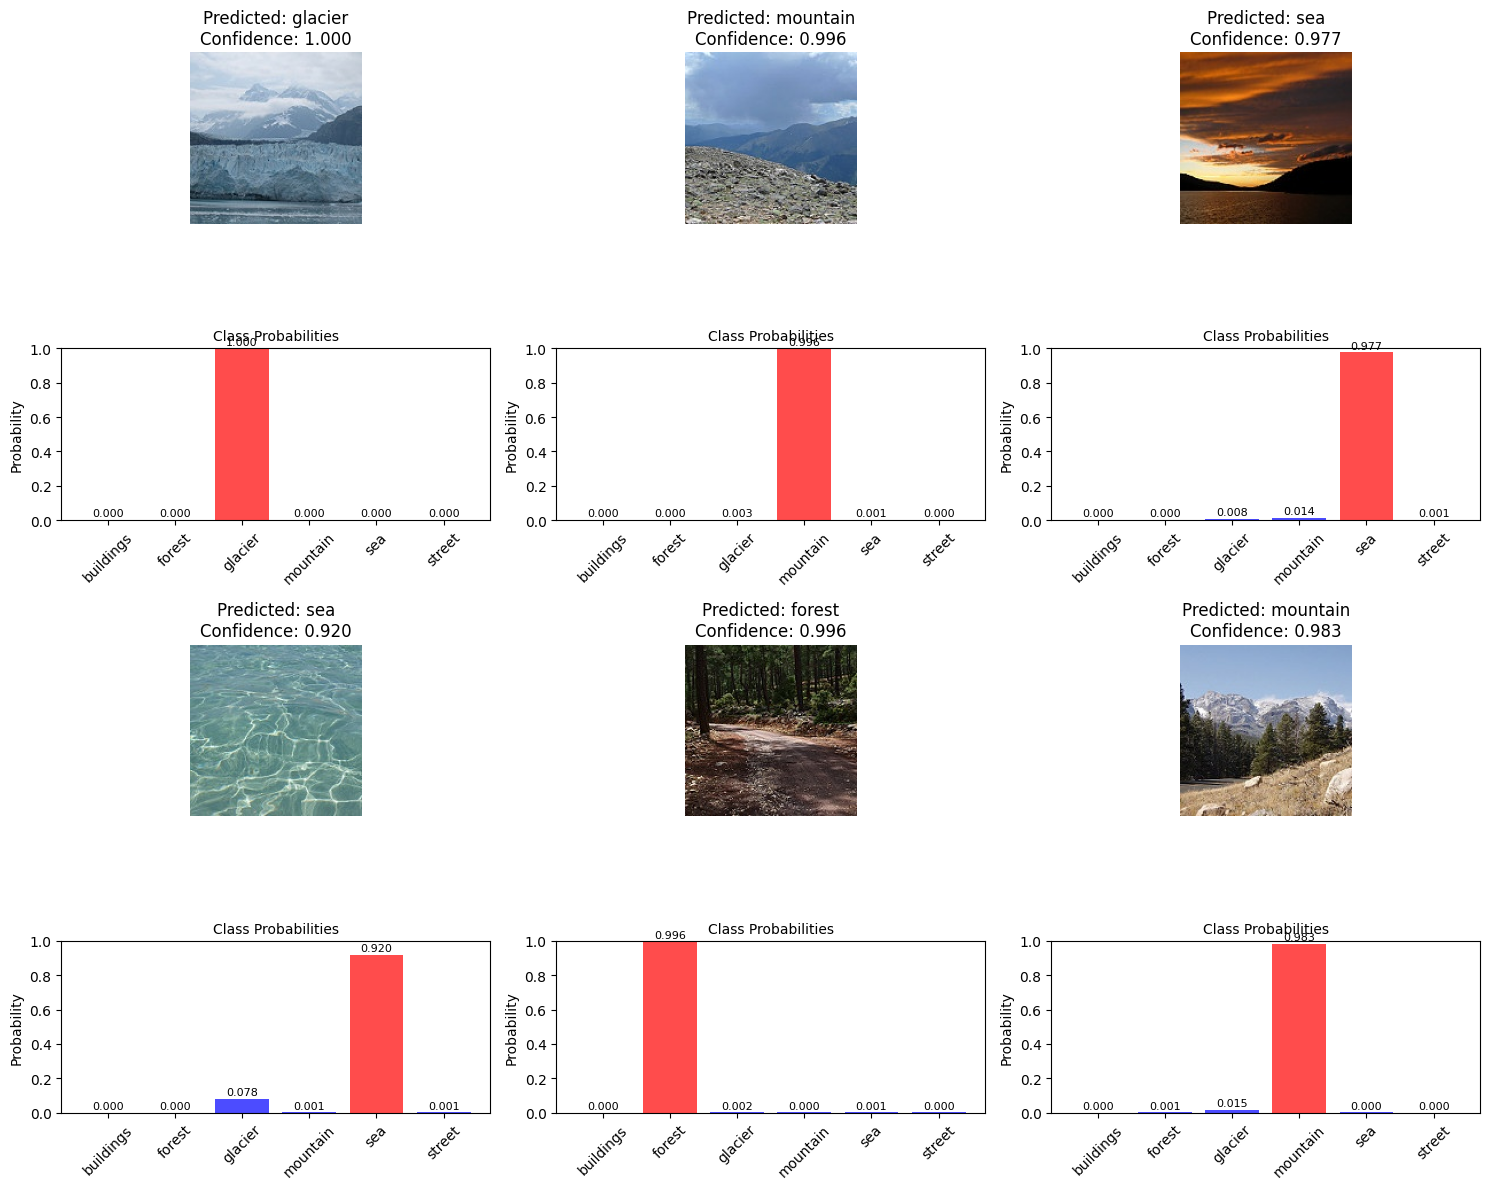


METHOD 2: PREDICTING IMAGES FROM PRED FOLDER
Found 6 images in pred folder:
  - 10004.jpg
  - 10005.jpg
  - 10012.jpg
  - 10013.jpg
  - 10017.jpg
  - 10021.jpg

Making predictions on pred images...
Predicting: 10004.jpg
  Predicted: buildings (Confidence: 0.9006)
----------------------------------------
Predicting: 10005.jpg
  Predicted: mountain (Confidence: 0.9315)
----------------------------------------
Predicting: 10012.jpg
  Predicted: street (Confidence: 0.9978)
----------------------------------------
Predicting: 10013.jpg
  Predicted: mountain (Confidence: 0.9852)
----------------------------------------
Predicting: 10017.jpg
  Predicted: mountain (Confidence: 0.8740)
----------------------------------------
Predicting: 10021.jpg
  Predicted: forest (Confidence: 0.9998)
----------------------------------------

Visualizing pred folder results...


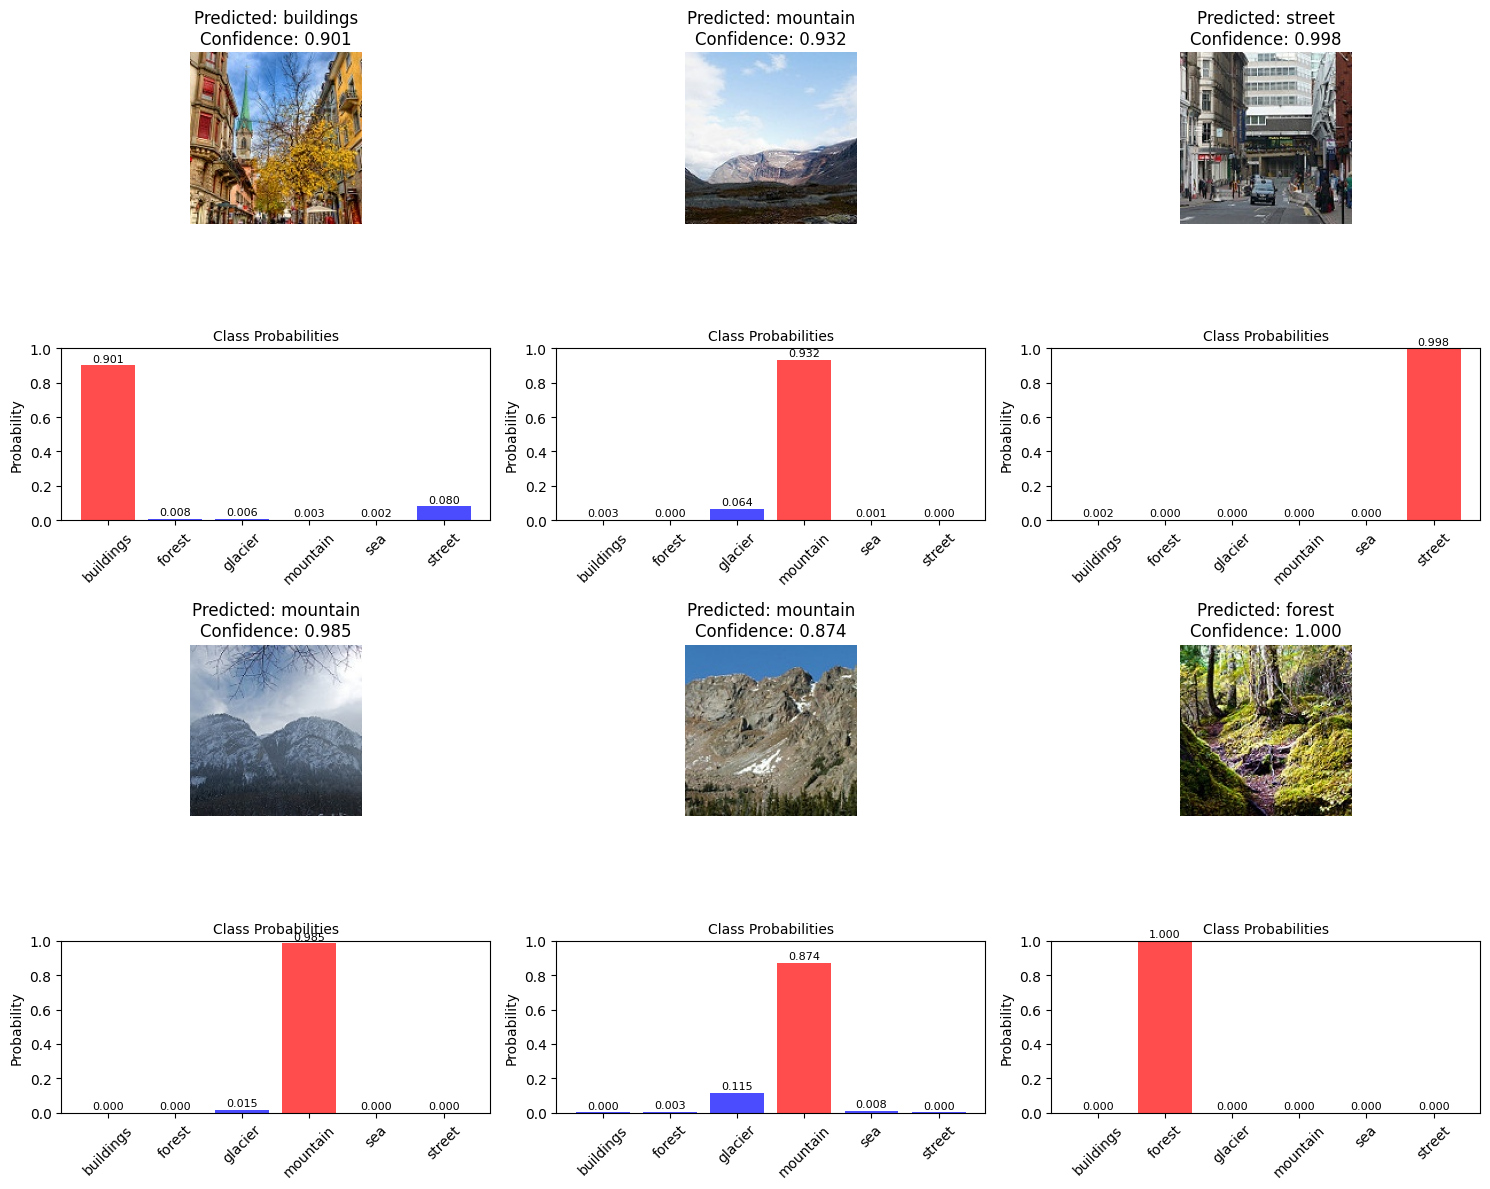


METHOD 3: SINGLE IMAGE PREDICTION EXAMPLE
Predicting single image: data/test\buildings\20057.jpg

🎯 Prediction Results:
   Image: 20057.jpg
   Predicted Class: buildings
   Confidence: 0.9999
   True Class: buildings

📊 All Class Probabilities:
   buildings: 0.9999
   forest: 0.0000
   glacier: 0.0000
   mountain: 0.0000
   sea: 0.0000
   street: 0.0000

PREDICTION COMPLETED!


In [11]:
# Load Trained Model and Make Predictions
print("="*60)
print("IMAGE PREDICTION WITH TRAINED RESNET MODEL")
print("="*60)

# Load the best trained model
try:
    print("Loading trained ResNet model...")
    checkpoint = torch.load('best_resnet_model.pth', map_location=device)
    
    # Create model with same architecture
    loaded_model = ResNet18(num_classes=nb_classes, dropout_rate=0.5)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.to(device)
    loaded_model.eval()
    
    print("✅ Model loaded successfully!")
    print(f"Model validation accuracy: {checkpoint['val_accuracy']:.4f}")
    print(f"Model was trained for epoch: {checkpoint['epoch'] + 1}")
    
except FileNotFoundError:
    print("❌ Model file 'best_resnet_model.pth' not found!")
    print("Please train the model first by running the training cells above.")
    loaded_model = None

if loaded_model is not None:
    # Method 1: Predict on random test images
    print("\n" + "="*50)
    print("METHOD 1: PREDICTING RANDOM TEST IMAGES")
    print("="*50)
    
    try:
        # Get random test images
        test_data_dir = "data/test"
        random_images = get_random_test_images(test_data_dir, num_images=6)
        
        if random_images:
            print(f"Selected {len(random_images)} random test images for prediction:")
            for img_path in random_images:
                print(f"  - {img_path}")
            
            # Make predictions
            print("\nMaking predictions...")
            prediction_results = predict_multiple_images(
                loaded_model, random_images, class_names, device
            )
            
            # Visualize results
            print("\nVisualizing prediction results...")
            visualize_predictions(prediction_results, class_names)
            
        else:
            print("❌ No test images found in 'data/test' directory")
            
    except Exception as e:
        print(f"❌ Error during random image prediction: {str(e)}")
    
    # Method 2: Predict specific images from pred folder
    print("\n" + "="*50)
    print("METHOD 2: PREDICTING IMAGES FROM PRED FOLDER")
    print("="*50)
    
    try:
        pred_data_dir = "data/pred"
        if os.path.exists(pred_data_dir):
            # Get first 6 images from pred folder
            pred_images = []
            for file in os.listdir(pred_data_dir):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    pred_images.append(os.path.join(pred_data_dir, file))
                if len(pred_images) >= 6:  # Limit to 6 images
                    break
            
            if pred_images:
                print(f"Found {len(pred_images)} images in pred folder:")
                for img_path in pred_images:
                    print(f"  - {os.path.basename(img_path)}")
                
                # Make predictions
                print("\nMaking predictions on pred images...")
                pred_results = predict_multiple_images(
                    loaded_model, pred_images, class_names, device
                )
                
                # Visualize results
                print("\nVisualizing pred folder results...")
                visualize_predictions(pred_results, class_names)
                
            else:
                print("❌ No images found in 'data/pred' directory")
        else:
            print("❌ 'data/pred' directory not found")
            
    except Exception as e:
        print(f"❌ Error during pred folder prediction: {str(e)}")
    
    # Method 3: Single image prediction example
    print("\n" + "="*50)
    print("METHOD 3: SINGLE IMAGE PREDICTION EXAMPLE")
    print("="*50)
    
    try:
        # Try to predict a single image
        single_image_path = None
        
        # Look for any image in test directory
        for class_folder in os.listdir("data/test"):
            class_path = os.path.join("data/test", class_folder)
            if os.path.isdir(class_path):
                for image_file in os.listdir(class_path):
                    if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        single_image_path = os.path.join(class_path, image_file)
                        break
                if single_image_path:
                    break
        
        if single_image_path:
            print(f"Predicting single image: {single_image_path}")
            
            predicted_class, confidence, probabilities = predict_single_image(
                loaded_model, single_image_path, class_names, device
            )
            
            if predicted_class:
                print(f"\n🎯 Prediction Results:")
                print(f"   Image: {os.path.basename(single_image_path)}")
                print(f"   Predicted Class: {predicted_class}")
                print(f"   Confidence: {confidence:.4f}")
                print(f"   True Class: {os.path.basename(os.path.dirname(single_image_path))}")
                
                print(f"\n📊 All Class Probabilities:")
                for i, (class_name, prob) in enumerate(zip(class_names, probabilities)):
                    print(f"   {class_name}: {prob:.4f}")
            else:
                print("❌ Failed to predict single image")
        else:
            print("❌ No test images found for single prediction")
            
    except Exception as e:
        print(f"❌ Error during single image prediction: {str(e)}")

print("\n" + "="*60)
print("PREDICTION COMPLETED!")
print("="*60)

In [15]:
import google.generativeai as genai
import PIL.Image
import os

# --- Configuration ---
# IMPORTANT: Replace "YOUR_API_KEY" with your actual Google AI API key.
# You can get a key from https://aistudio.google.com/app/apikey
# It's recommended to set this as an environment variable for security.
API_KEY = os.getenv("GOOGLE_API_KEY")

# The name of the image file you want to describe.
# Make sure this image is in the same folder as your Python script.
IMAGE_FILE = "data/pred/5.jpg" 

# --- Code ---
try:
    # Configure the API key
    genai.configure(api_key=API_KEY)

    # Open the image file
    img = PIL.Image.open(IMAGE_FILE)

    # Initialize the Gemini Pro Vision model
    model = genai.GenerativeModel('gemini-2.0-flash')

    # Generate the content
    # The prompt asks the model for a concise, one-line description.
    response = model.generate_content(["Give a one-line description of this image.", img])

    # Print the generated description
    print(response.text)

except FileNotFoundError:
    print(f"Error: The file '{IMAGE_FILE}' was not found. Please make sure it's in the same directory as the script.")
except Exception as e:
    print(f"An error occurred: {e}")

The image shows a city skyline with tall buildings reflecting the warm colors of a sunset or sunrise.



In [ ]:
# Load and use the trained model for prediction
try:
    # Configuration
    model_path = "best_resnet_model.pth"
    class_names = ['buildings','forest','glacier','mountain', 'sea','street']
    class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
    nb_classes = len(class_names)
    IMAGE_SIZE = (224, 224)  # Standard ResNet input size
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Using device: {device}")
    print("Loading trained ResNet model...")
    
    # Load the model checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create model with same architecture
    loaded_model = ResNet18(num_classes=nb_classes, dropout_rate=0.5)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.to(device)
    loaded_model.eval()
    
    print("✅ Model loaded successfully!")
    print(f"Model validation accuracy: {checkpoint['val_accuracy']:.4f}")
    
    # Now predict the image using the LOADED MODEL OBJECT (not the filename string)
    image_path = "data/pred/5.jpg"
    print(f"\nPredicting image: {image_path}")
    
    predicted_class, confidence, probabilities = predict_single_image(
        loaded_model,
        image_path, 
        class_names, 
        device
    )
    
    if predicted_class:
        print(f"\n🎯 Prediction Results:")
        print(f"   Image: {os.path.basename(image_path)}")
        print(f"   Predicted Class: {predicted_class}")
        print(f"   Confidence: {confidence:.4f}")
        
        print(f"\n📊 All Class Probabilities:")
        for class_name, prob in zip(class_names, probabilities):
            print(f"   {class_name}: {prob:.4f}")
    else:
        print("❌ Failed to predict image")
        
except FileNotFoundError as e:
    print(f"❌ Model file not found: {e}")
    print("Please make sure 'best_resnet_model.pth' exists in the current directory")
except Exception as e:
    print(f"❌ Error: {e}")

Using device: cuda
Loading trained ResNet model...
✅ Model loaded successfully!
Model validation accuracy: 0.9010

Predicting image: data/pred/5.jpg

🎯 Prediction Results:
   Image: 5.jpg
   Predicted Class: buildings
   Confidence: 0.9800

📊 All Class Probabilities:
   buildings: 0.9800
   forest: 0.0000
   glacier: 0.0001
   mountain: 0.0000
   sea: 0.0033
   street: 0.0167
✅ Model loaded successfully!
Model validation accuracy: 0.9010

Predicting image: data/pred/5.jpg

🎯 Prediction Results:
   Image: 5.jpg
   Predicted Class: buildings
   Confidence: 0.9800

📊 All Class Probabilities:
   buildings: 0.9800
   forest: 0.0000
   glacier: 0.0001
   mountain: 0.0000
   sea: 0.0033
   street: 0.0167


In [25]:
def predict_image_class(image_path):
    """
    Simple function that takes an image path and returns predicted class and confidence
    
    Args:
        image_path (str): Path to the image file
    
    Returns:
        None
    """
    try:
        # Configuration
        model_path = "best_resnet_model.pth"
        class_names = ['buildings','forest','glacier','mountain', 'sea','street']
        nb_classes = len(class_names)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load the model checkpoint (only if not already loaded)
        if not hasattr(predict_image_class, 'loaded_model'):
            checkpoint = torch.load(model_path, map_location=device)
            
            # Create model with same architecture
            predict_image_class.loaded_model = ResNet18(num_classes=nb_classes, dropout_rate=0.5)
            predict_image_class.loaded_model.load_state_dict(checkpoint['model_state_dict'])
            predict_image_class.loaded_model.to(device)
            predict_image_class.loaded_model.eval()
        
        # Use the predict_single_image function
        predicted_class, confidence, _ = predict_single_image(
            predict_image_class.loaded_model,
            image_path, 
            class_names, 
            device
        )
        
        return predicted_class, confidence
        
    except Exception as e:
        return "None"

# Test with an image
test_image = "data/pred/15.jpg"
predicted_class, confidence = predict_image_class(test_image)

predicted_class


Error processing image data/pred/15.jpg: Could not load image from data/pred/15.jpg


In [ ]:
import google.generativeai as genai
import PIL.Image
import os

# --- Configuration ---
# IMPORTANT: Replace "YOUR_API_KEY" with your actual Google AI API key.
# You can get a key from https://aistudio.google.com/app/apikey
# It's recommended to set this as an environment variable for security.
API_KEY = os.getenv("GOOGLE_API_KEY")

# The name of the image file you want to describe.
# Make sure this image is in the same folder as your Python script.
IMAGE_FILE = "data/pred/5.jpg" 

# --- Code ---
try:
    # Configure the API key
    genai.configure(api_key=API_KEY)

    # Open the image file
    img = PIL.Image.open(IMAGE_FILE)

    # Initialize the Gemini Pro Vision model
    model = genai.GenerativeModel('gemini-2.0-flash')

    # Generate the content
    # The prompt asks the model for a concise, one-line description.
    response = model.generate_content(["Give a one-line description of this image.", img])

    # Print the generated description
    print(response.text)

except FileNotFoundError:
    print(f"Error: The file '{IMAGE_FILE}' was not found. Please make sure it's in the same directory as the script.")
except Exception as e:
    print(f"An error occurred: {e}")

In [32]:
import google.generativeai as genai
import PIL.Image
import os
import torch 
# You'll need to have your ResNet18 and predict_single_image functions defined or imported
# from your_model_utils import ResNet18, predict_single_image 

# --- Your Existing Prediction Function ---
# NOTE: Make sure your model file "best_resnet_model.pth" and the necessary
# helper functions (ResNet18, predict_single_image) are available.

def predict_image_class(image_path):
    """
    Simple function that takes an image path and returns predicted class and confidence
    
    Args:
        image_path (str): Path to the image file
    
    Returns:
        tuple (str, float) or str: (predicted_class, confidence) on success, "None" on failure.
    """
    try:
        # Configuration
        model_path = "best_resnet_model.pth"
        class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
        nb_classes = len(class_names)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load the model checkpoint (only if not already loaded for efficiency)
        if not hasattr(predict_image_class, 'loaded_model'):
            print("Loading model for the first time...")
            checkpoint = torch.load(model_path, map_location=device)
            
            # Create model with same architecture (ensure ResNet18 is defined)
            predict_image_class.loaded_model = ResNet18(num_classes=nb_classes, dropout_rate=0.5)
            predict_image_class.loaded_model.load_state_dict(checkpoint['model_state_dict'])
            predict_image_class.loaded_model.to(device)
            predict_image_class.loaded_model.eval()
            print("Model loaded.")
            
        # Use the predict_single_image function (ensure it's defined)
        predicted_class, confidence, _ = predict_single_image(
            predict_image_class.loaded_model,
            image_path, 
            class_names, 
            device
        )
        
        return predicted_class, confidence
        
    except Exception as e:
        print(f"Error in local model prediction: {e}")
        return "None", 0.0 # Return a tuple for consistency

# --- New Integrated Gemini Function ---

def generate_integrated_description(image_path):
    """
    Generates a one-line description of an image, integrating a local model's prediction.
    """
    # 1. Get prediction from your local model first
    predicted_class, confidence = predict_image_class(image_path)

    # 2. Configure Gemini API
    # IMPORTANT: Replace "YOUR_API_KEY" with your actual Google AI API key.
    API_KEY = os.getenv("GOOGLE_API_KEY")
    genai.configure(api_key=API_KEY)
    
    # 3. Prepare the image for Gemini
    try:
        img = PIL.Image.open(image_path)
    except FileNotFoundError:
        return f"Error: Image file not found at {image_path}"

    # 4. Create a dynamic prompt based on your model's output
    prompt_parts = []
    
    if predicted_class != "None" and confidence is not None:
        # SUCCESS CASE: Your model worked
        confidence_percent = confidence * 100
        prompt = (f"My custom model confidently predicts this is an image of a '{predicted_class}' "
                  f"({confidence_percent:.1f}% confidence). Please provide a single descriptive sentence "
                  f"that confirms this prediction while adding one other visual detail you see.Also mention the my model's outputs")
    else:
        # FAILURE CASE: Your model failed
        prompt = ("Please provide a single descriptive sentence for this image. "
                  "Note that my separate custom classification model failed to identify it.")

    prompt_parts.extend([prompt, img])
    
    # 5. Call the Gemini API
    model = genai.GenerativeModel('gemini-2.0-flash')
    response = model.generate_content(prompt_parts)
    
    return response.text


# Test with an image
test_image_path = "data/pred/5.jpg" # Make sure this path is correct
final_description = generate_integrated_description(test_image_path)

print("\n--- Final Integrated Description ---")
print(final_description)

Loading model for the first time...
Model loaded.

--- Final Integrated Description ---
Here's a confirmation of your model's prediction with an additional detail, referencing the output:

Confirmed at 98.0% confidence as 'buildings', the image shows a cluster of modern skyscrapers reflecting the warm hues of a sunset.
